<a href="https://colab.research.google.com/github/pedroAndrad1/introducao_a_aprendizado_nao_supervisionado/blob/master/introducao_aprendizado_nao_supervisionado_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vamos agora clusterizar(agrupar) as instancias do dataset, baseado nos seu genêros, usando o KMeans do módulo cluster da biblioteca sklearn.

Para entender melhor como o kmeans funciona, segue um link para um representação gráfica:
https://www.naftaliharris.com/blog/visualizing-k-means-clustering/


# Recapitulando

In [0]:
import pandas as pd

uri = 'https://raw.githubusercontent.com/oyurimatheus/clusterirng/master/movies/movies.csv'
filmes = pd.read_csv(uri)
filmes.head()

#vou renomear as colunas usando o atributo columns que recebe um array de strings com os nomes.
filmes.columns = ["filme_id" , "titulo", "genero"] # Bem mais facil do que usar rename(dicionario).

#Vou extrair os dummies da coluna generos, para  ficar mais facil saber qual e o genero do filme.
#Muito mais facil em varias colunas de sim ou nao do que ler uma string com varios generos seperados.

genero_dummies = filmes.genero.str.get_dummies()

#Agora vou concatenar o dataframe generos_dummies com o dataframe filmes, usando o pandas.

filmes = pd.concat([filmes, genero_dummies], axis = 1) # axis = 1 para concatenar na horizontal, nao e assim para toda funcao.

#Para melhor clusterizar as instancias, e bom saber qual genero pesa mais.
#Exemplo, toy story e muito mais uma animacao do que uma comedia.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
genero_escalado = scaler.fit_transform(genero_dummies, genero_dummies)#A funcao fit_transform() e a juncao da fit() e tranform().

#1 Instanciando o KMeans.

Quando o kmeans é instanciado, temos que passar um parâmetro, n_clusters = x, tal que o x é o número de grupos que desejamos. Ou seja, é o número de centróides que o kmeans vai usar no processo de agrupamento.

In [2]:
from sklearn.cluster import KMeans

modelo = KMeans(n_clusters = 3) #Vou agrupar as intancias do dataset em tres grupos.

#Vou fazer o agrupamento com a funcao fit, passando como parametro os generos reescalados.
modelo.fit(genero_escalado)

print(f"Grupos: {modelo.labels_}")

#Podemos ver que cada instancia do dataset esta em um grupo

Grupos: [2 2 0 ... 0 2 0]


#2 Visualizando os agrupamentos (Centróides) por meio de um gráfico de barras

Vou usar a função plot() do pandas para criar um gráfico a partir de um dataframe e a função bar()
para ser um gráfico de barras.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9cbc35e48>,
      dtype=object)

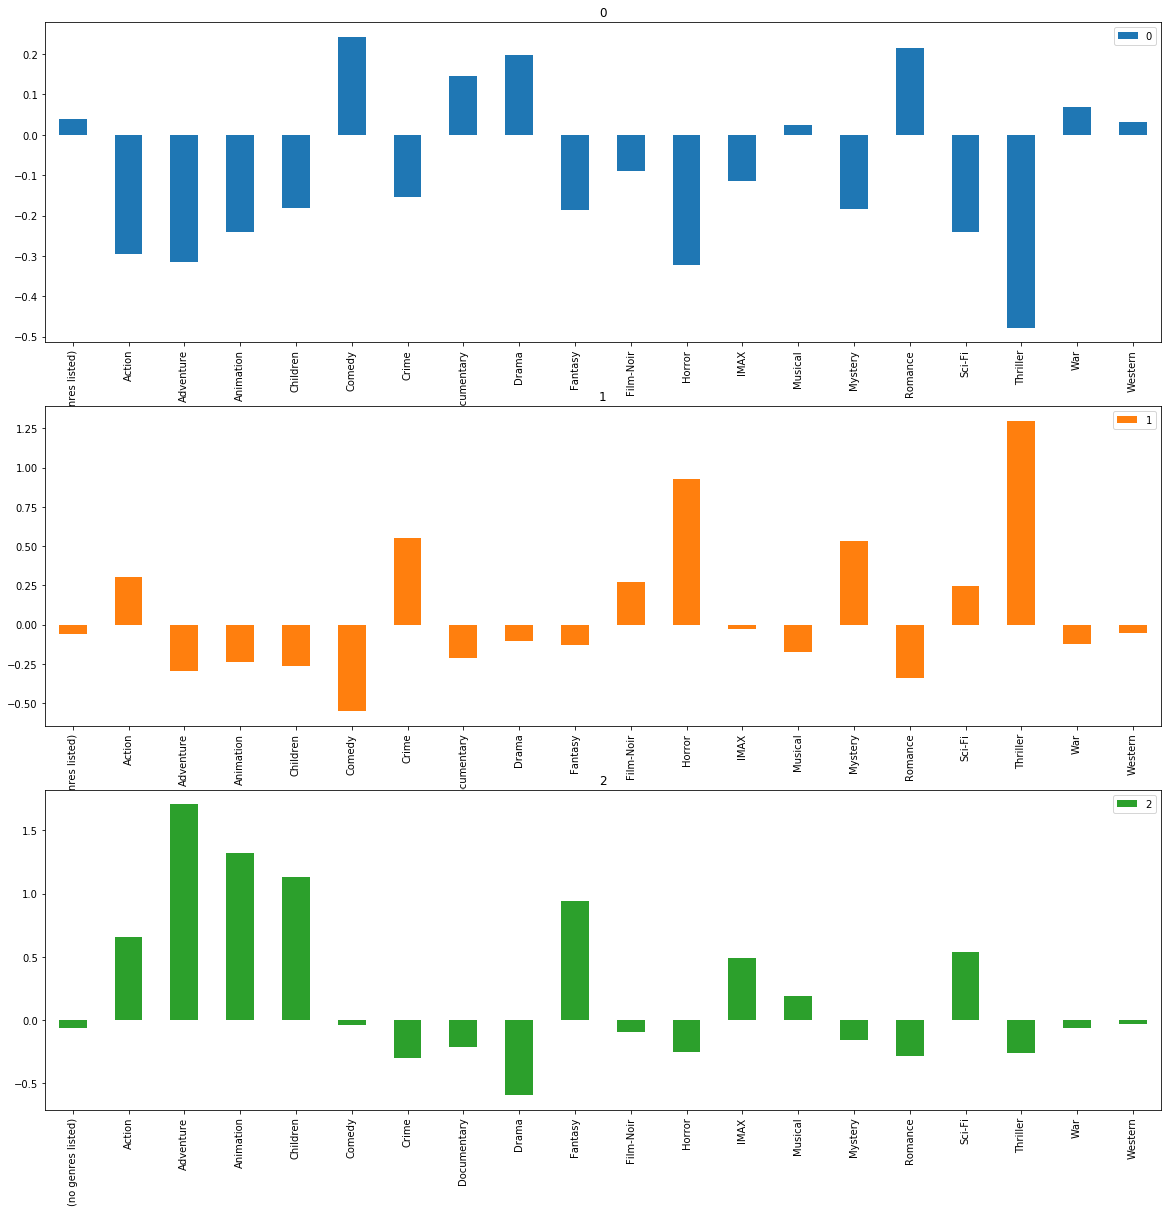

In [3]:
#Primeiro, queremos um dataframe que tenha nossos agrupamentos de generos.
#Entao, com o pandas, vou criar um dataframe em que as linhas sao os generos e as colunas os grupos.

#O KMeans tem um atributo chamado cluster_centers_ que sao os valores das dimensoes, nesse caso 20, uma para cada genero, em cada um dos agrupamentos.
#Esse devem ser os valores do nosso grafico. Entao, vou fazer o panda criar um grafico a partir dessas informacoes e o nomes da colunas serao os generos dos filmes,
#que estao no nosso dataframe de dummies.

grupos = pd.DataFrame(modelo.cluster_centers_, columns = genero_dummies.columns)

#Mas se eu plotar isso, o pandas vai me dar um grafico de barras em relacao as colunas que sao os generos, eu quero em relacao aos grupos, que sao as linhas.
#Entao, antes de mandar o pandas plotar, vou transpor esse dataframe, do mesmo jeito que se faz com uma matriz. Usando a funcao transpose(), do pandas.

grupos = grupos.transpose()

#Como eu quero que seja um grafico para cada coluna, vou passar o atributo subplots = True.
#Para ser uma figura maior que o default, vou passar o atributo figsize = (x,x) como parametro.
#Vou tambem passar o atributo sharex = False, para cada subplot ter seu proprio eixo x. Facilitando a leitura do grafico.

grupos.plot.bar(subplots = True, figsize = (20,20), sharex = False )

#3 Fazendo um gráfico de dispersão para os agrupamentos

Vamos usar a biblioteca seaborn para plotar um gráfico de dispersão(scatterplot) a partir dos dados dos agrupamentos. Para fazer isso, precisamos reduzir a dimensão dos dados, que são 20, para 2. Usarei o TSNE do módulo manifold da biblioteca sklearn para fazer esse redisionamento. Aqui vai acontecer algo interessante, quando plotarmos o gráfico, vai parecer que os agrupamentos não foram feitos corretamente. Mas, teremos essa impressão porque, quando fazemos o redisionamento, temos perda de informações. Então acontecerá algo parecido com uma ilusão de ótica, em 2d vemos uma coisa que paree errada, mas se fossemos capazer de ver em 20 dimensões, poderíamsos os agrupamentos da forma correta.

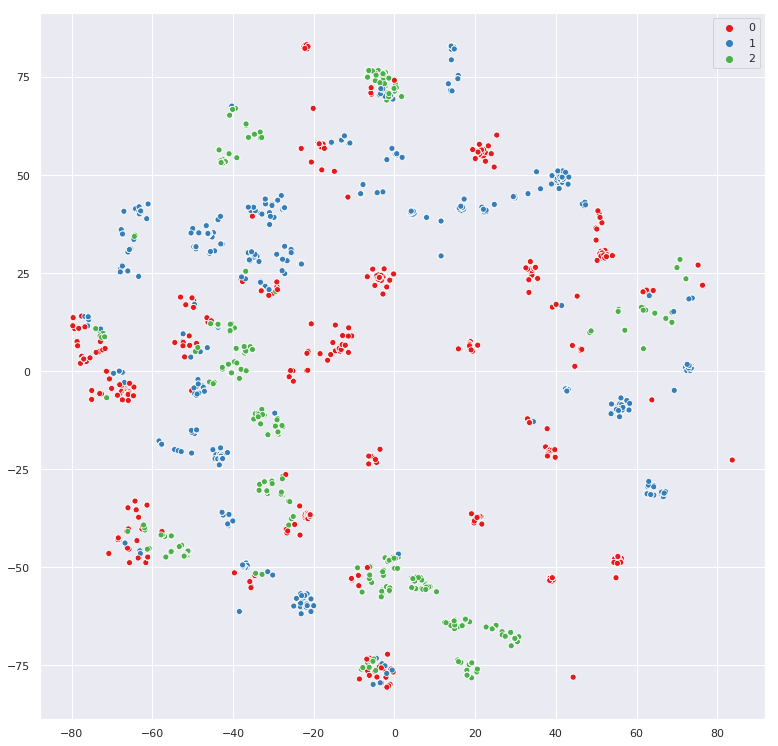

In [4]:
from sklearn.manifold import TSNE

tsne = TSNE()
#Assim como os modelos, o tsne vai se ajustar aos dados e os transformar para um array 2d.
visualizacao = tsne.fit_transform(genero_escalado)

#Agora vamos plotar isso com o seaborn.
import seaborn as sns

#O eixo x serão todos os valores da primeira coluna da visualizacao, [:, 0] e eixo y todos os valores da segunda coluna, [:, 1].
#Tambem vou passar como parametro o atributo hue = modeli.labels_ para ele separar as cores dos pontos por cada grupo.
#E vou passar como parametro o atributo  palette=sns.color_palette('Set1', 3) pra ter cores mais vivas.
#Vou usar a funcao set() passando como parametro o atributo rc igual a um dicionario com a chave figure.figsize: (x,x) para aumentar o tamanho do plot.

sns.set( rc = {"figure.figsize": (13,13)})
sns.scatterplot( x = visualizacao[:, 0], y = visualizacao[:, 1] , hue = modelo.labels_,  palette=sns.color_palette('Set1', 3) )

#4 Quantos grupos devemos ter? Elbow method

Caso usemos poucos grupos, podemos ter elementos de grupos diferentes no mesmo grupo. Porém, caso usemos muitos, elementos que deveriam estar no mesmo grupo podem acabar em grupos diferentes. Para resolver isso, usamos o elbow method, ou método do cotovelo. O KMeans tem um atributo chamado inertia_, que é o erro quadradatíco de cada clusterização. Se fizessimos um grpafico em que o eixo sãa as quantidades de grupos e o eixo y é a inertia_. Veríamos que x e y são inversamente proporcionais. Mas tem um ponto do gráfico em que há uma "quebra". Esse ponto é o número de cluster's ideal. O gráfico parece um braço dobrado e esse ponto seria o cotovelo, por isso o nome.

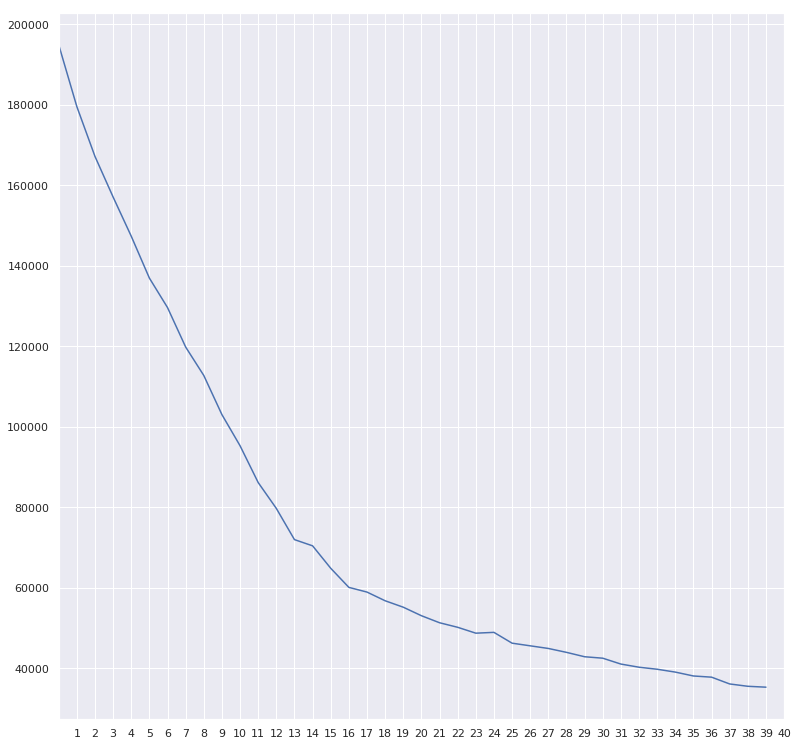

In [12]:
#Vamos conseguir essas informações do eixo x e y com um lopping for

#Primeiro, vamos fazer uma funcao para receber como parametro a quantidade de 
#grupos e os generos, fazer um modelo do KMeans e retornar a quantidade grupos e a inertia.

def inertia (quantidade_de_grupos, genero_escalado):
  modelo = KMeans(n_clusters = quantidade_de_grupos)
  modelo.fit(genero_escalado)
  
  return [quantidade_de_grupos, modelo.inertia_]

#Agora vamos fazer um lopping for de 1 a 40, chamando inertia() para cada iterecao,passando o contador como a quantidade de grupos
#e colocando cada retorno em array. Por fim, salvamos esse array em uma variavel. TUDO EM UMA LINHA! Parabéns, python3.

resultados = [inertia(quantidade_de_grupos, genero_escalado) for quantidade_de_grupos in range(1, 41)]

#Feito isso, vamos transformar esse array em um dataframe usando o pandas

dataframe_resultados = pd.DataFrame(resultados, columns = ["Quantidade_de_grupos", "Inertia"])

#Vamos plotar esse dataframe em um grafico de linhas para vermos o cotovelo. 
#Vou passar o atributo xticks = dataframe_resultados.quantide_de_grupos para o eixo x ser o número de grupos.
#Caso contrário o eixo x comecaria do zero ate um numero maior que 40, estranho nao?
#E vou mandar plotar um grafico so da coluna Inertia pra termos so uma linha.

dataframe_resultados.Inertia.plot( xticks = dataframe_resultados.Quantidade_de_grupos )
 
#Veja que no ponto onde x e igual a 16, a velocidade com que a inertia estava caindo comecou a diminuir.
#Podemos entao ver que o ponto de quebra e o ponto onde x e igual a 16, entao 16 grupos e o ideal.

Vamos entao fazer a clusterizacao com o numero ideal de grupos e ver como ficam os agrupamentos plotando um grafico de barras usando o pandas.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9c55f7eb8>,
      dtype=object)

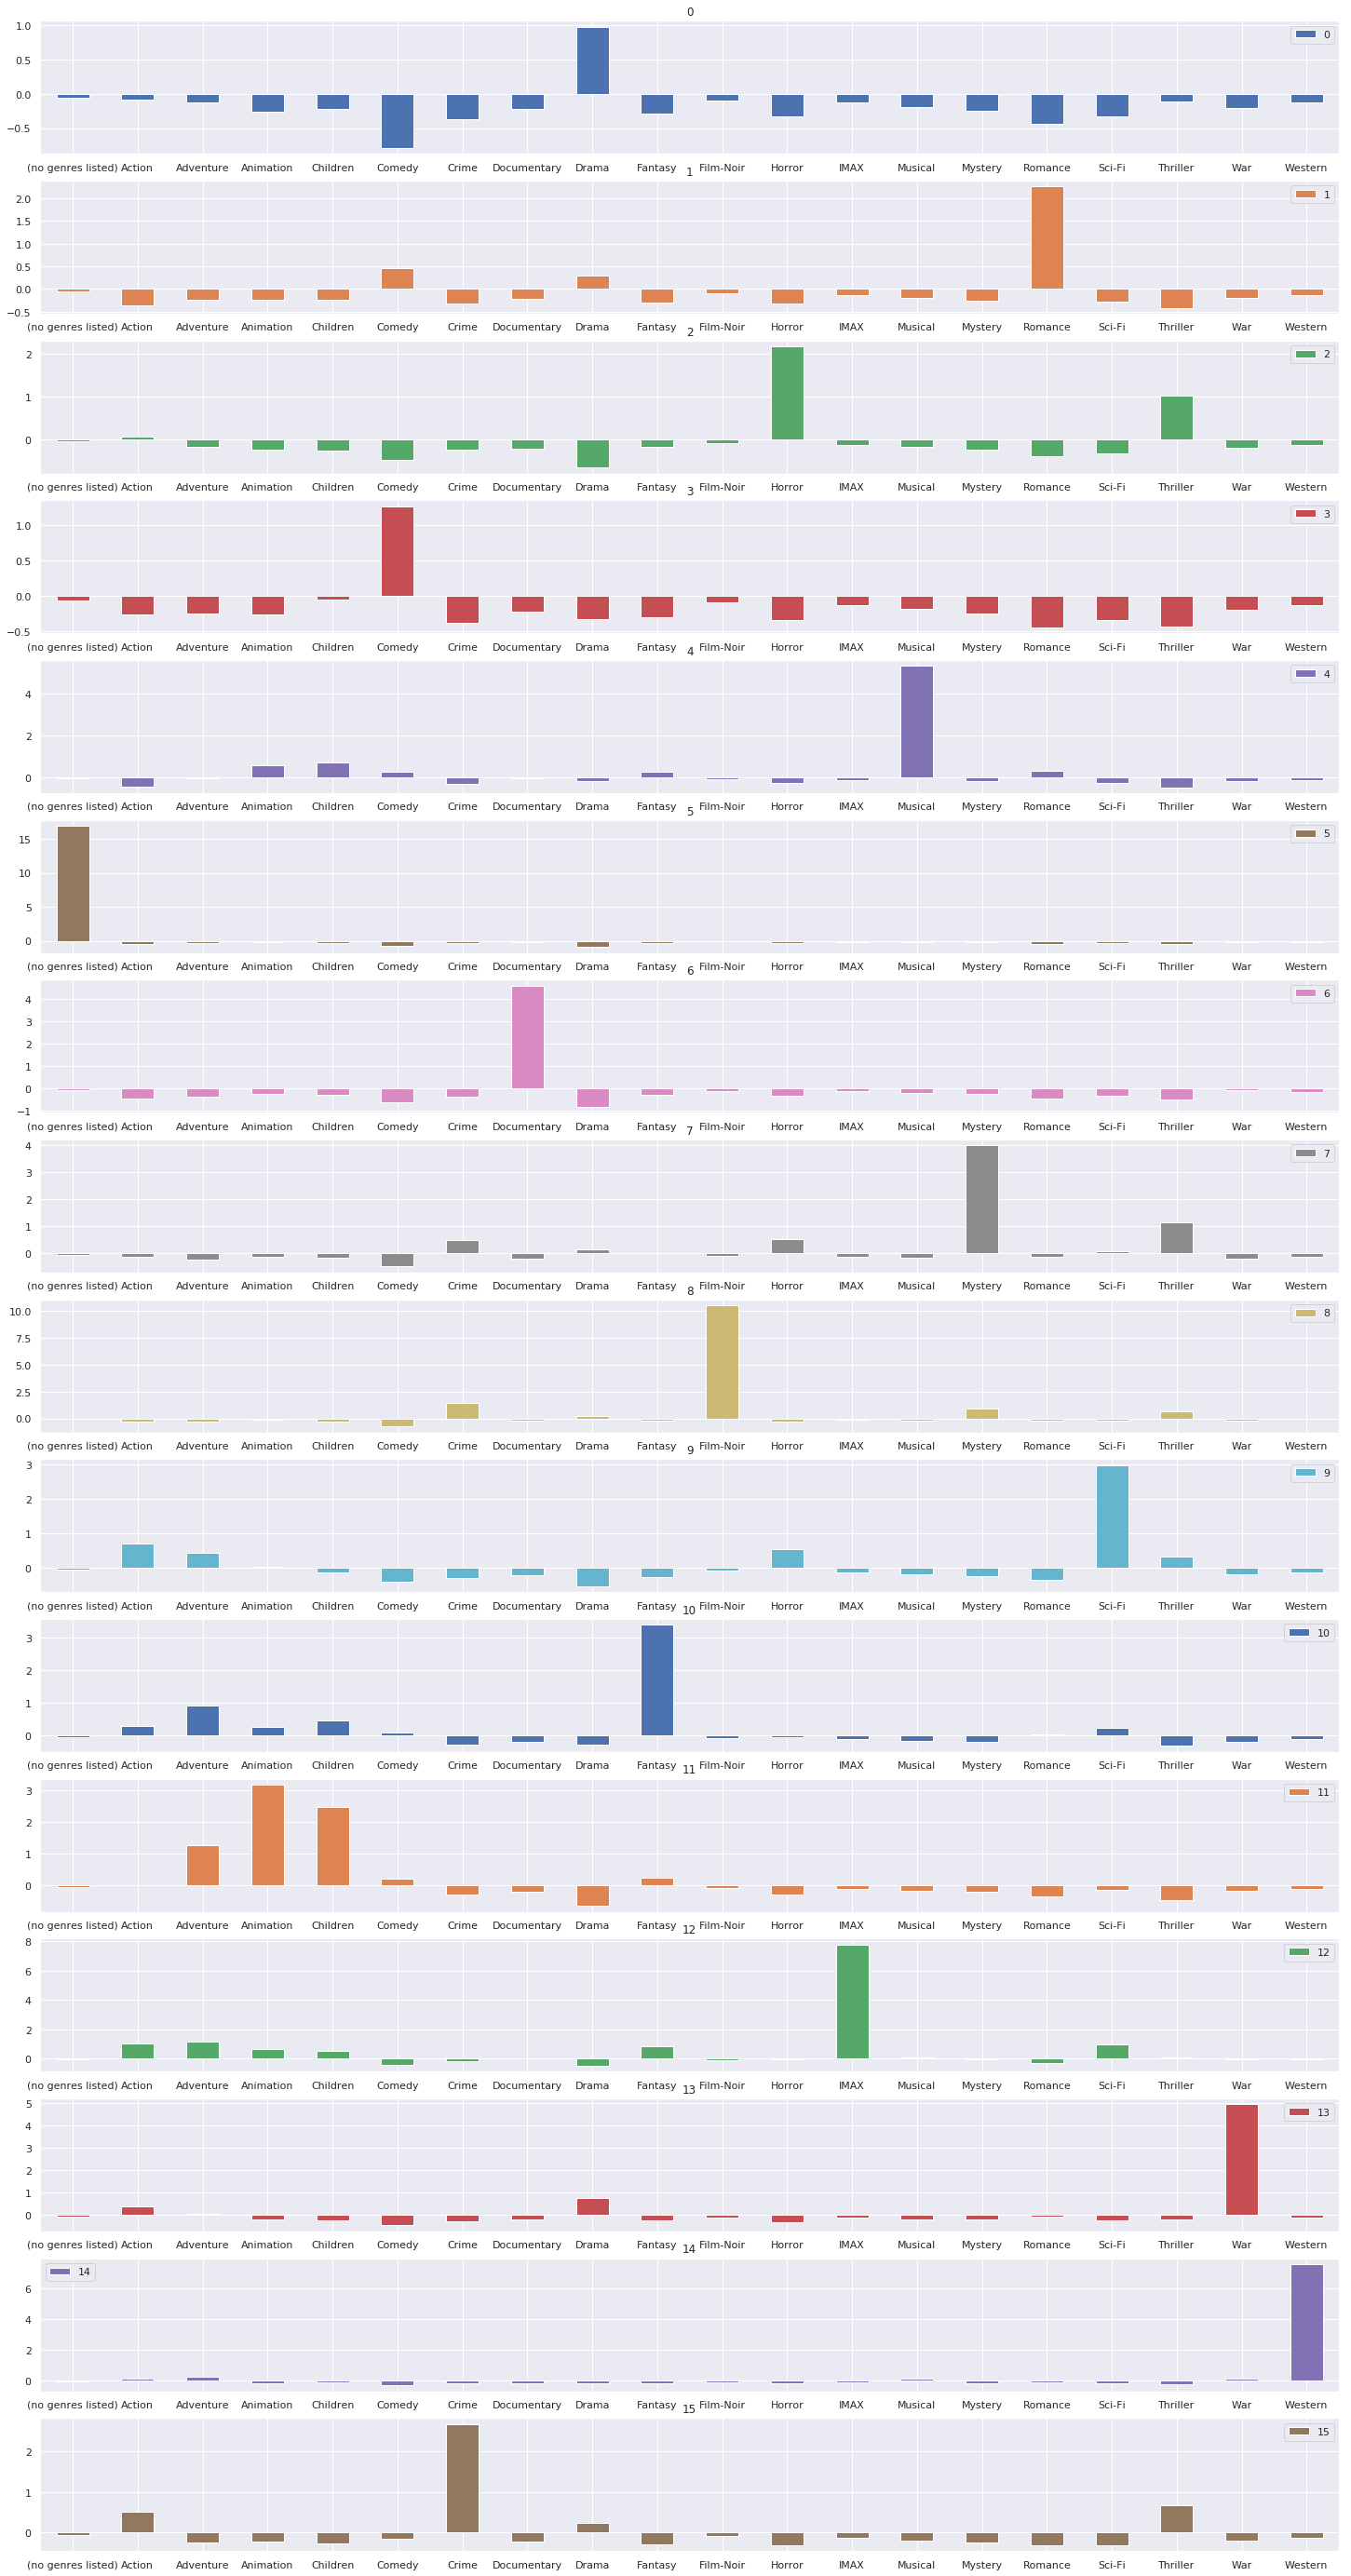

In [16]:
modelo = KMeans(n_clusters = 16)
modelo.fit(genero_escalado)

grupos = pd.DataFrame(modelo.cluster_centers_, columns = genero_dummies.columns)

#Alem dos atributos que vimos anteriormente, vou passar o atributo rot=0 pros elementos do eixo ficarem na horizontal.
#Assim ficam melhor para ler.
grupos.transpose().plot.bar(subplots=True,
               figsize=(25, 50),
               sharex=False,
               rot=0)

#5 Agrupando de forma hierárquica

O KMeans agrupa os dados de forma particionada, mas existe outras formas de agrupa-los, como a forma hierárquica. Para isso, vamos usar o AgglomerativeClustering do módulo cluster da biblioteca sklearn.

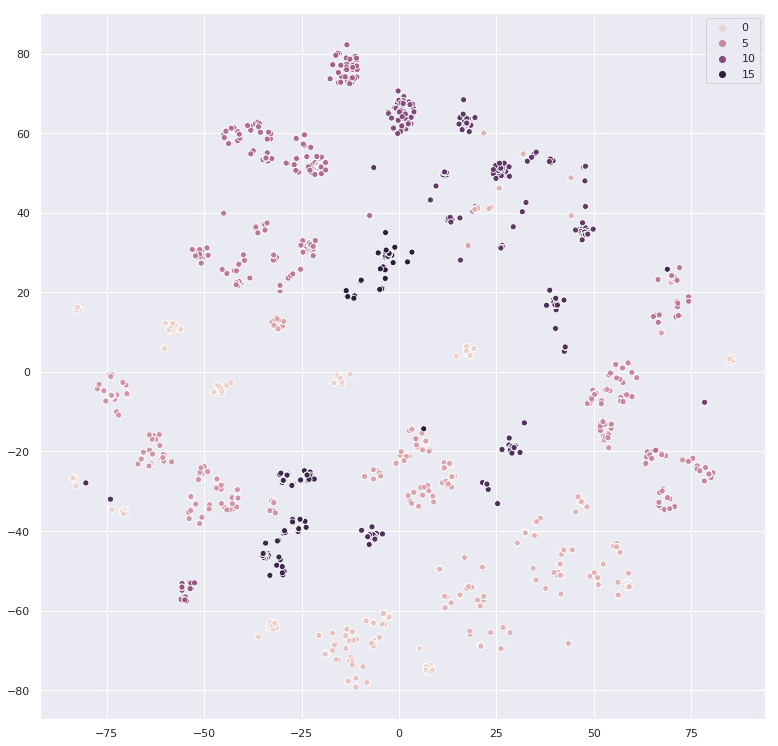

In [20]:
from sklearn.cluster import AgglomerativeClustering

modelo_agc = AgglomerativeClustering(n_clusters = 16)

grupos_agc = modelo_agc.fit_predict(genero_escalado)

#Feito o agrupamento, vamos plotar esse agrupamento em um grafico de dispersao usando o seaborn.
#Antes precisamos redimensionar os dados para 2d usando o TSNE

visualizacao = tsne.fit_transform(genero_escalado)

#Agora, basta plotar com um gráfico de dispersao passando como parametro de cores os grupos criados pelo AgglomerativeClustering.

sns.scatterplot(x = visualizacao[:,0] , y = visualizacao[:, 1], hue = grupos_agc)

#Podemos ver os dados agrupados em hierarquias.

#6 Criando um dendrograma

Uma forma de ver quais grupos estão mais próximos de outros, é através de um dendrograma. Para plotar um, vamos precisar da matriz de distâncias, que a distância da cada centróide em relação aos outros. 

Vamos usar o linkage pra calcular a matriz de distâncias e o dendrogram para plotar o gráfico. Ambos são do módulo cluster.hierarchy da biblioteca scipy (Não é do sklearn dessa vez kk).

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9c464b438>,
      dtype=object)

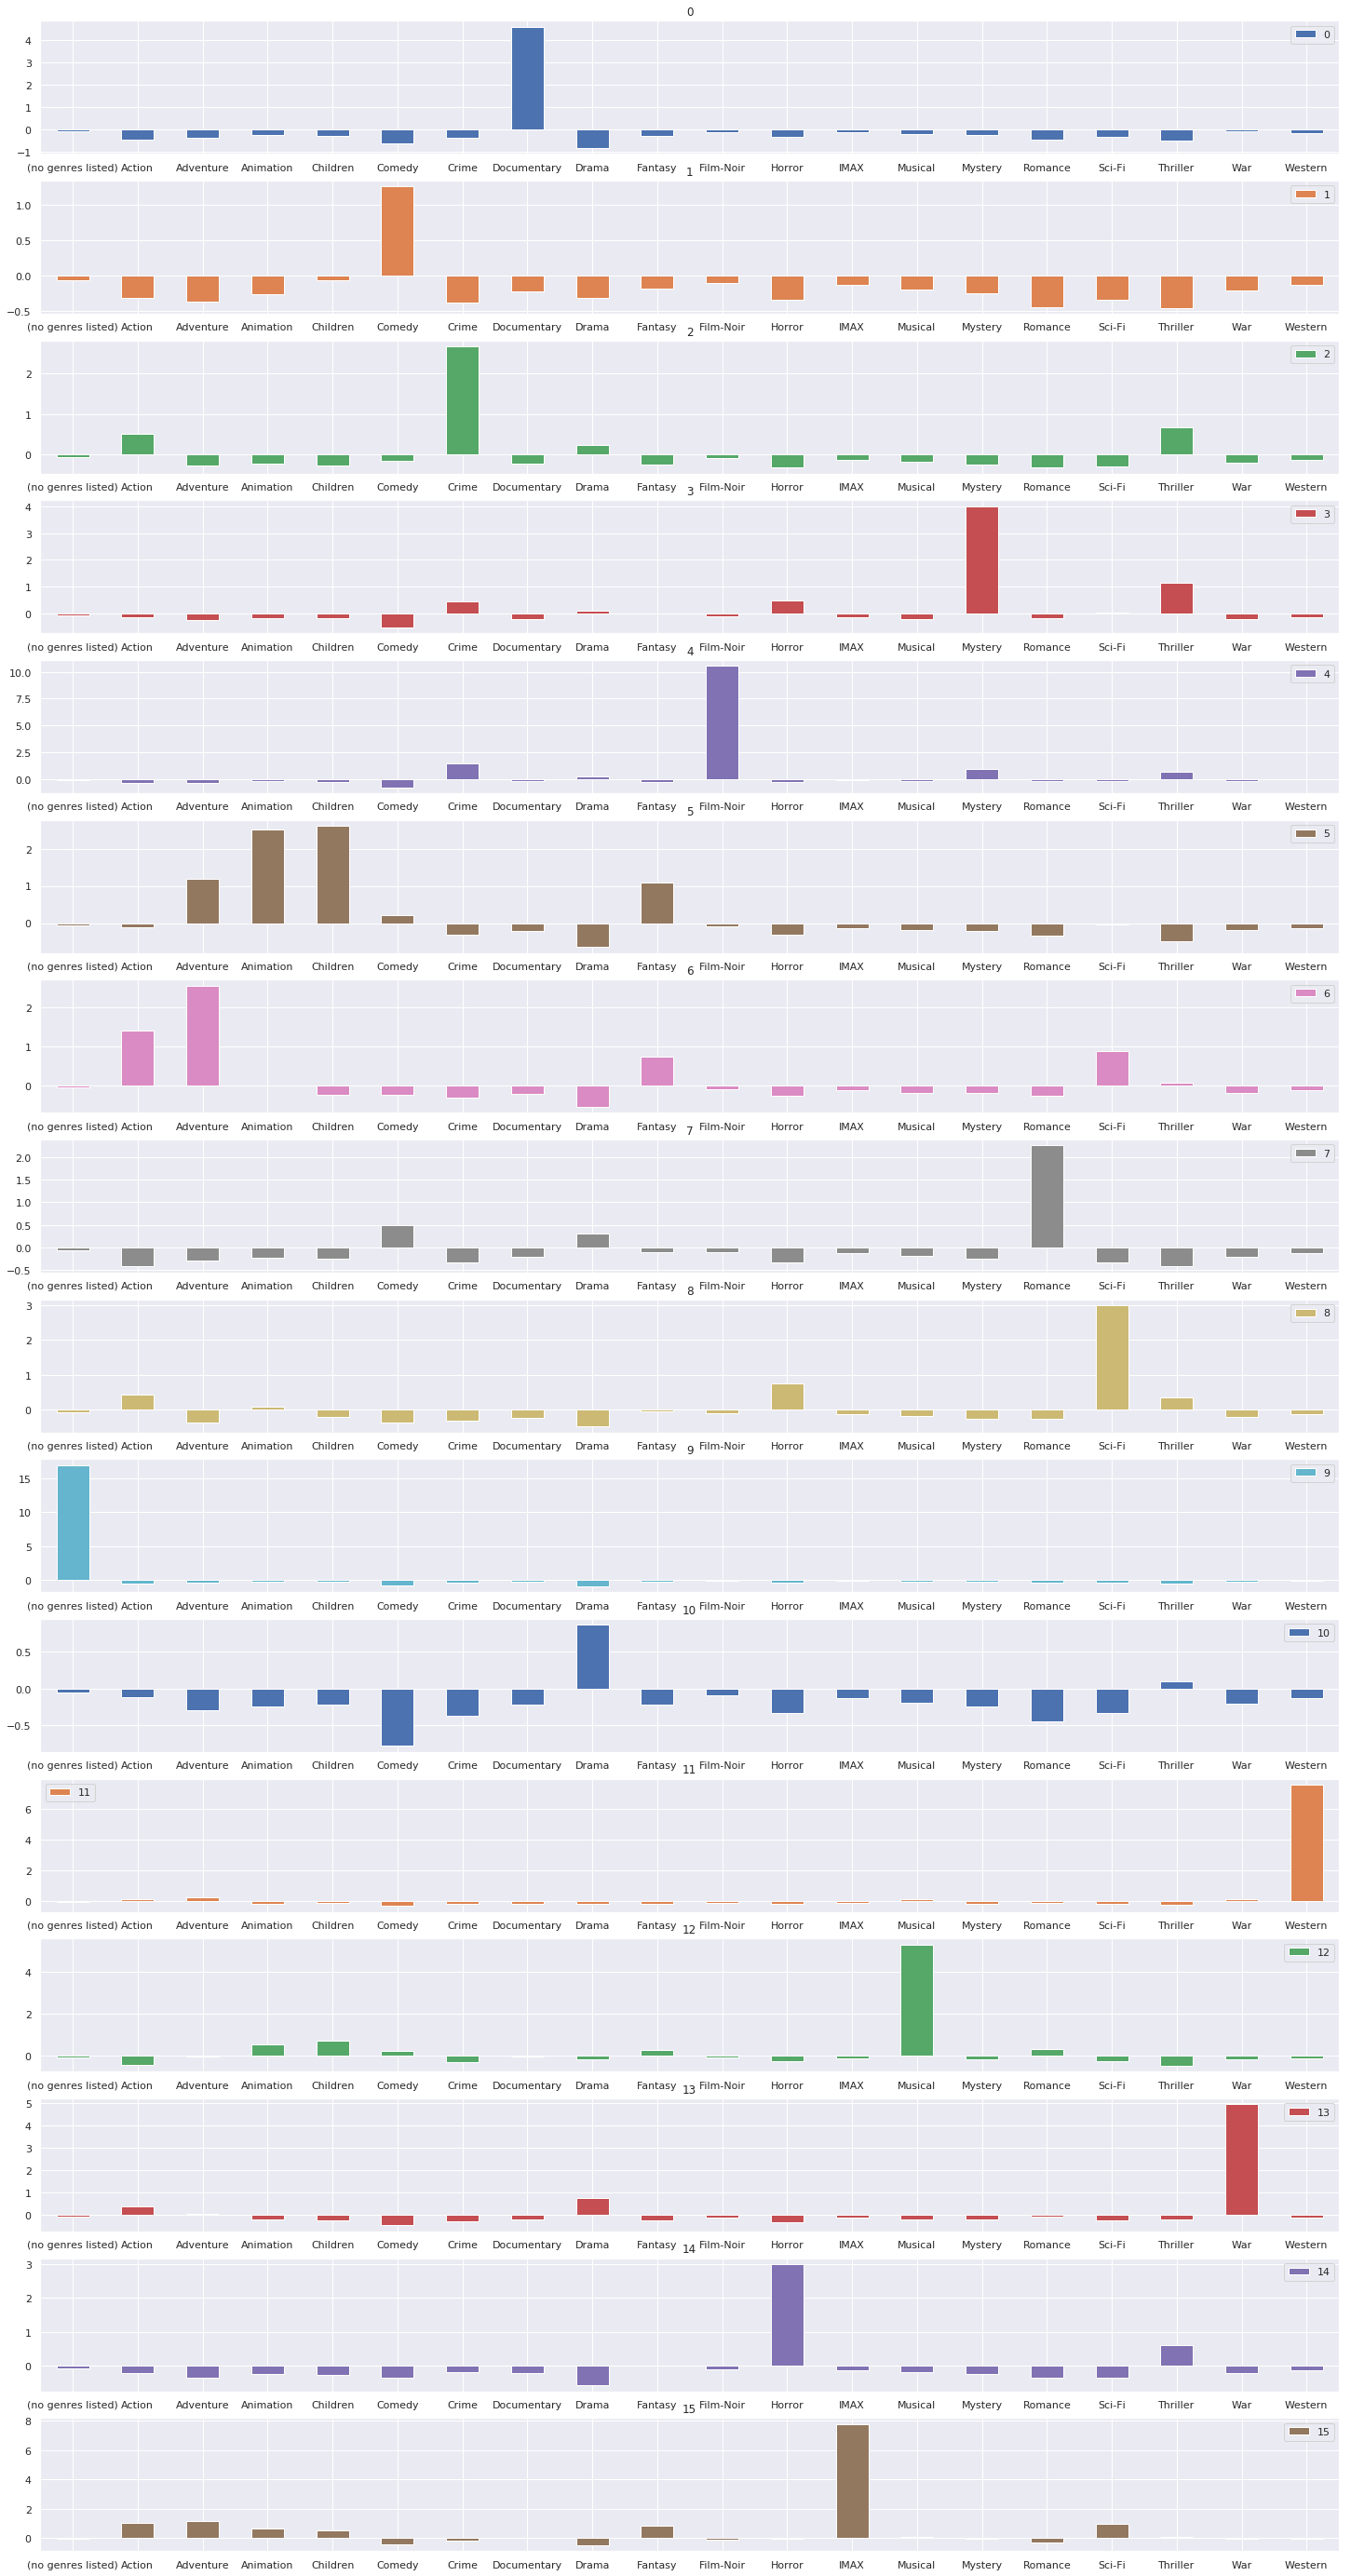

In [28]:
#Criei um novo modelo KMeans porque a variavel grupos virou um array em algum lugar que não achei.
modelo = KMeans(n_clusters = 16)
modelo.fit(genero_escalado)

grupos = pd.DataFrame(modelo.cluster_centers_, columns = genero_dummies.columns)

grupos.transpose().plot.bar(subplots=True,
               figsize=(25, 50),
               sharex=False,
               rot=0)

#Vou plotar tambem um novo grafico de barras pra poder comparar com o dendograma e ver quais generos estao proximos de outros.

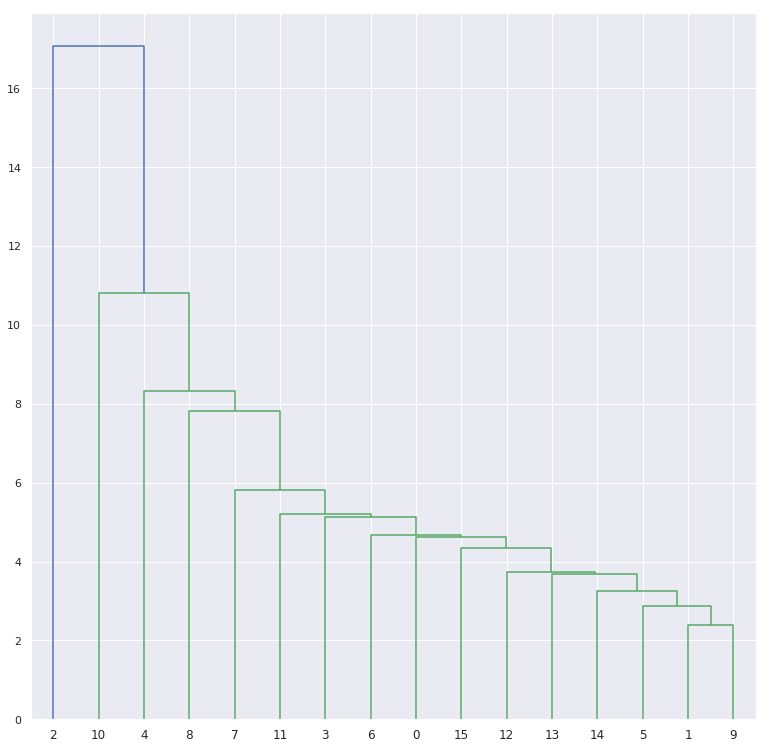

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage

matriz_de_distancias = linkage(grupos) #Estou passando os grupos criados pelo KMeans. Porque queremos saber a distancia entre os centroides do KMeans.

dendrograma = dendrogram(matriz_de_distancias) #Ele já plota com a atribuicao, estranho.